### Make timeseries of SIA, NPP, KGP, and penguins for 7 regions

In [1]:
import intake
import matplotlib.pyplot as plt
import xarray as xr
from distributed import Client
from ncar_jobqueue import NCARCluster
import dask
import numpy as np
import pop_tools
import warnings
warnings.filterwarnings('ignore')
import cartopy
import cartopy.crs as ccrs
import utils
from glob import glob
import numpy as np
import matplotlib.path as mpath
import cmocean

import cartopy.feature as cfeature
import matplotlib.ticker as mticker

### Get grid info

In [2]:
ds_grid = pop_tools.get_grid('POP_gx1v7').isel(nlat=slice(0,55))
lats = ds_grid.TLAT
lons = ds_grid.TLONG
area = ds_grid.TAREA
lons_norm = utils.normal_lons(lons)

area_km2 = area * 1e-10

In [3]:
years = np.arange(1920,2101,1)

In [4]:
years = xr.DataArray(years,dims=('time'))

### Make a SIZ mask, so then we can do an area-weighted average for each longitude

In [5]:
## based on CESM1-LE -- will redo!!
ds_siz_mask = xr.open_dataset('/glade/u/home/kristenk/antarc_marine_pred_work/TOE/SIZ_mask_1920-50-CESM2LE_15percentJJA.nc')
ds_siz_mask = ds_siz_mask.isel(nlat=slice(0,55))

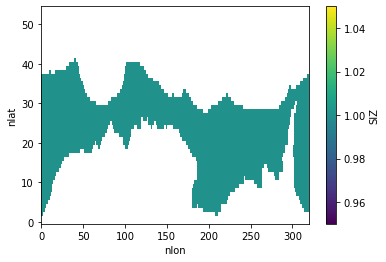

In [6]:
ds_siz_mask.SIZ.plot()

In [7]:
siz_mask = ds_siz_mask.SIZ

### Add maps below for one interesting season for each variable

    • ICE - SON
    • NPP - ONDJFM
    • zooC = JFM
    • KGP = JFM
    • fish total = annual
    • fish ice = annual
    • Emperor = annual
    • Adelie = annual

In [8]:
file = '/glade/derecho/scratch/kristenk/ToE_saved_data/CESM2-LE-seasonal-integrals-NPP.nc'
ds_npp = xr.open_dataset(file)
ds_npp = ds_npp.isel(time=slice(70,250))
ds_npp = ds_npp.isel(nlat=slice(0,55))
ds_npp

<xarray.Dataset>
Dimensions:     (member_id: 50, nlat: 55, nlon: 320, time: 180)
Coordinates:
  * time        (time) int64 1920 1921 1922 1923 1924 ... 2096 2097 2098 2099
Dimensions without coordinates: member_id, nlat, nlon
Data variables:
    NPP_ONDJFM  (time, member_id, nlat, nlon) float64 ...
    NPP_OND     (time, member_id, nlat, nlon) float64 ...
    NPP_JFM     (time, member_id, nlat, nlon) float64 ...
    NPP_AMJ     (time, member_id, nlat, nlon) float64 ...
    NPP_JAS     (time, member_id, nlat, nlon) float64 ...
Attributes:
    author:          Kristen Krumhardt
    date_processed:  2025-03-03
    contents:        yearly NPP in the Southern Ocean from 1850 to 2099. Each...

In [9]:
ds_npp.NPP_ONDJFM.attrs

{'units': 'mmol/m2/season'}

In [10]:
file = '/glade/derecho/scratch/kristenk/ToE_saved_data/CESM2-LE-seasonal-means-IFRAC-hi_v4.nc'
ds_ice = xr.open_dataset(file)
ds_ice = ds_ice.isel(time=slice(70,250))
ds_ice

<xarray.Dataset>
Dimensions:       (member_id: 50, nlat: 55, nlon: 320, time: 180)
Coordinates:
  * time          (time) int64 1920 1921 1922 1923 1924 ... 2096 2097 2098 2099
Dimensions without coordinates: member_id, nlat, nlon
Data variables:
    IFRAC_ONDJFM  (time, member_id, nlat, nlon) float64 ...
    IFRAC_OND     (time, member_id, nlat, nlon) float64 ...
    IFRAC_JFM     (time, member_id, nlat, nlon) float64 ...
    IFRAC_JAS     (time, member_id, nlat, nlon) float64 ...
    IFRAC_SON     (time, member_id, nlat, nlon) float64 ...
    IFRAC_MAM     (time, member_id, nlat, nlon) float64 ...
    IFRAC_AMJ     (time, member_id, nlat, nlon) float64 ...
    SIT_OND       (time, member_id, nlat, nlon) float64 ...
    SIT_JFM       (time, member_id, nlat, nlon) float64 ...
    SIT_AMJ       (time, member_id, nlat, nlon) float64 ...
    SIT_JAS       (time, member_id, nlat, nlon) float64 ...
    SIT_ONDJFM    (time, member_id, nlat, nlon) float64 ...
Attributes:
    author:          Kristen Krumhardt
    date_processed:  2025-03-03
    contents:        yearly ifrac in the Southern Ocean from 1850 to 2099. Ea...

In [11]:
file = '/glade/derecho/scratch/kristenk/ToE_saved_data/CESM2-LE-seasonal-integrals-KGP.nc'
ds_kgp = xr.open_dataset(file)
ds_kgp = ds_kgp.isel(nlat=slice(0,55))
ds_kgp = ds_kgp.isel(time=slice(70,250))
ds_kgp

<xarray.Dataset>
Dimensions:     (member_id: 50, nlat: 55, nlon: 320, time: 180)
Coordinates:
  * time        (time) int64 1920 1921 1922 1923 1924 ... 2096 2097 2098 2099
Dimensions without coordinates: member_id, nlat, nlon
Data variables:
    KGP_ONDJFM  (time, member_id, nlat, nlon) float64 ...
    KGP_OND     (time, member_id, nlat, nlon) float64 ...
    KGP_JFM     (time, member_id, nlat, nlon) float64 ...
Attributes:
    author:          Kristen Krumhardt
    date_processed:  2024-01-23
    contents:        yearly KGP in the Southern Ocean from 1850 to 2099. Each...

In [12]:
ds_kgp['KGP_OND'] = ds_kgp['KGP_OND'].where(ds_kgp['KGP_OND']>0,other=0)
ds_kgp['KGP_JFM'] = ds_kgp['KGP_JFM'].where(ds_kgp['KGP_JFM']>0,other=0)

In [13]:
ds_kgp #['KGP_JFM'].isel(time=179,member_id=0).plot()

<xarray.Dataset>
Dimensions:     (member_id: 50, nlat: 55, nlon: 320, time: 180)
Coordinates:
  * time        (time) int64 1920 1921 1922 1923 1924 ... 2096 2097 2098 2099
Dimensions without coordinates: member_id, nlat, nlon
Data variables:
    KGP_ONDJFM  (time, member_id, nlat, nlon) float64 ...
    KGP_OND     (time, member_id, nlat, nlon) float64 0.0 0.0 0.0 ... 0.0 0.0
    KGP_JFM     (time, member_id, nlat, nlon) float64 0.0 0.0 0.0 ... 0.0 0.0
Attributes:
    author:          Kristen Krumhardt
    date_processed:  2024-01-23
    contents:        yearly KGP in the Southern Ocean from 1850 to 2099. Each...

In [14]:
ds_fish = xr.open_dataset('/glade/derecho/scratch/kristenk/ToE_saved_data/FEISTY_ann_tot_fish.nc')

In [15]:
ds_fish = ds_fish.isel(time=slice(70,250))

In [16]:
ds_fish

<xarray.Dataset>
Dimensions:             (fish: 8, group: 9, member_id: 50, nlat: 55, nlon: 320, time: 180)
Coordinates:
  * fish                (fish) object 'Sf' 'Sp' 'Sd' 'Mf' 'Mp' 'Md' 'Lp' 'Ld'
  * group               (group) object 'Sf' 'Sp' 'Sd' ... 'Ld' 'benthic_prey'
  * nlat                (nlat) int64 0 1 2 3 4 5 6 7 ... 47 48 49 50 51 52 53 54
  * nlon                (nlon) int64 0 1 2 3 4 5 6 ... 314 315 316 317 318 319
  * time                (time) int64 1920 1921 1922 1923 ... 2096 2097 2098 2099
Dimensions without coordinates: member_id
Data variables:
    total_forage        (member_id, time, nlat, nlon) float64 ...
    total_pelagic       (member_id, time, nlat, nlon) float64 ...
    total_demersal      (member_id, time, nlat, nlon) float64 ...
    total_fish          (member_id, time, nlat, nlon) float64 ...
    total_forage_ice    (member_id, time, nlat, nlon) float64 ...
    total_pelagic_ice   (member_id, time, nlat, nlon) float64 ...
    total_demersal_ice  (member_id, time, nlat, nlon) float64 ...
    total_fish_ice      (member_id, time, nlat, nlon) float64 ...

### Put all these together into one dataset

In [17]:
ds = xr.Dataset()
ds['NPP_ONDJFM'] = ds_npp.NPP_ONDJFM
ds['NPP_OND'] = ds_npp.NPP_OND
ds['NPP_JFM'] = ds_npp.NPP_JFM
ds['IFRAC_SON'] = ds_ice.IFRAC_SON
ds['IFRAC_MAM'] = ds_ice.IFRAC_MAM
ds['IFRAC_OND'] = ds_ice.IFRAC_OND
ds['IFRAC_JFM'] = ds_ice.IFRAC_JFM
ds['SIT_JFM'] = ds_ice.SIT_JFM
ds['SIT_OND'] = ds_ice.SIT_OND
ds['SIT_ONDJFM'] = ds_ice.SIT_ONDJFM
ds['IFRAC_ONDJFM'] = ds_ice.IFRAC_ONDJFM
ds['KGP_JFM'] = ds_kgp.KGP_JFM
ds['KGP_OND'] = ds_kgp.KGP_OND
ds['KGP_ONDJFM'] = ds_kgp.KGP_ONDJFM
ds['total_fish'] = ds_fish.total_fish
ds['total_fish_ice'] = ds_fish.total_fish_ice

#### get emperor penguin timeseries data

In [18]:
import pandas as pd

In [19]:
years = np.arange(1920,2101,1)
regs = ['AP','EAnt','Wedd','Adelie','Ross','AmBel','Prydz']
sims = np.arange(0,500,1)

In [20]:
emp_dict = {}
i=1
for reg in regs:
    file = '/glade/work/kristenk/penguin_data/regions/R_region_'+str(i)+'.csv'
    df_emp = pd.read_csv(file,header=None)
    df_emp['year'] = years
    ##### calculate mean!
    df_emp['mean']= df_emp[sims].mean(axis=1)
    emp_dict[reg] = df_emp
    i = i + 1

In [21]:
emp_dict.keys()

dict_keys(['AP', 'EAnt', 'Wedd', 'Adelie', 'Ross', 'AmBel', 'Prydz'])

In [22]:
emp_dict['AP']

,0,1,2,3,4,5,6,7,8,9,...,492,493,494,495,496,497,498,499,year,mean
0,0.965385,0.965693,0.964787,0.964606,0.964311,0.965324,0.966267,0.965243,0.965071,0.964108,...,1.004450,1.002487,1.004999,1.004653,1.002721,1.008184,1.004494,1.003470,1920,1.008851
1,1.016994,0.946077,1.016427,1.016355,1.016126,1.016943,0.945752,1.016879,1.016739,1.015959,...,1.023702,1.021696,0.937256,1.023906,1.021953,1.027621,1.023744,1.022714,1921,1.009523
2,1.012765,1.015963,1.012196,1.012167,1.011962,1.012718,1.017133,1.012658,0.944201,1.011807,...,1.004823,1.003053,1.010964,1.005001,1.003289,1.008291,1.004860,1.003956,1922,1.008202
3,0.945821,1.019410,1.016974,1.016966,1.016779,1.017488,1.020606,1.017432,1.020995,1.016634,...,1.022520,1.020941,1.026271,1.022678,1.021159,1.025646,0.942296,1.021752,1923,1.011993
4,1.017602,1.014361,1.012911,0.938151,1.012725,1.013489,1.015764,1.013429,1.015707,1.012567,...,1.027764,1.026253,1.030300,1.027914,1.026465,1.030765,1.032839,1.027032,1924,1.009049
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176,0.726487,0.726491,0.556576,0.726491,0.770700,0.726490,0.726473,0.726491,0.726469,0.726441,...,0.733774,0.737571,0.733799,0.733785,0.733799,0.733710,0.733793,0.733799,2096,0.750757
177,0.699783,0.699784,0.737679,0.699784,0.722075,0.699784,0.699772,0.699784,0.699647,0.699729,...,0.780575,0.781704,0.780601,0.780588,0.780601,0.780455,0.780596,0.780601,2097,0.745005
178,0.721689,0.721687,0.730288,0.721687,0.726615,0.721688,0.721683,0.576358,0.721554,0.721652,...,0.763265,0.763910,0.597367,0.763270,0.763276,0.763222,0.763273,0.763276,2098,0.735891
179,0.759168,0.759166,0.762514,0.759166,0.760894,0.759167,0.759163,0.779258,0.759032,0.759134,...,0.643587,0.786447,0.810294,0.786265,0.786272,0.786182,0.786270,0.786272,2099,0.734931


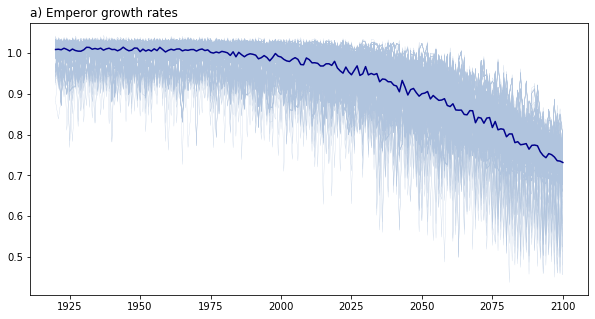

In [23]:
fig = plt.figure(figsize=(10,5))

#cmap = 'ice_cats'
#################
ax = fig.add_subplot(1, 1, 1)
ax.set_title("a) Emperor growth rates", loc="left", fontsize=12)
for mem in np.arange(0,500,1):

    ax.plot(years, emp_dict['AP'][mem], color='lightsteelblue',linewidth=0.2)
    
ax.plot(years, emp_dict['AP']['mean'],
           color='darkblue', zorder=2)



#### get Adelie penguin data (log(µ))

In [24]:
sims = np.arange(0,50,1)

adel_regs = ['AP','Adelie','Ross','AmBel','Prydz']

adelie_dict = {}
i=0
for reg in ['1','4','5','6','7']:
    
    file = '/glade/work/kristenk/penguin_data/regions_Adelie/r_region' + reg +'_adpe.csv'
    df_ad_reg = pd.read_csv(file)
    df_ad_reg = df_ad_reg.T #transpose data file
    df_ad_reg['mean'] = df_ad_reg[sims].mean(axis=1)
    adelie_dict[adel_regs[i]] = df_ad_reg
    i = 1 + 1

In [25]:
adelie_dict['AP']

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,mean
1939,0.004131,0.003243,0.008363,0.003408,0.002381,0.007911,0.006663,0.005096,0.009493,0.008092,...,0.003294,0.001713,0.007814,0.006084,0.002021,0.003754,0.009717,0.003696,0.003692,0.005298
1940,0.004689,0.003670,0.008159,0.004138,0.002435,0.008131,0.006416,0.005349,0.009496,0.007918,...,0.003682,0.002150,0.008331,0.006489,0.001861,0.004008,0.010207,0.004415,0.004499,0.005476
1941,0.004528,0.004243,0.007931,0.004542,0.002578,0.008792,0.006346,0.005855,0.009565,0.008252,...,0.003916,0.002637,0.008686,0.006844,0.001724,0.004723,0.010594,0.004927,0.004917,0.005763
1942,0.005117,0.004656,0.008234,0.004572,0.003294,0.008946,0.006436,0.006247,0.009645,0.008441,...,0.003788,0.002762,0.008765,0.006691,0.001997,0.004899,0.010192,0.004864,0.004958,0.005946
1943,0.005764,0.005111,0.007943,0.004774,0.004006,0.008760,0.006501,0.006134,0.010110,0.008594,...,0.004337,0.003308,0.009327,0.006813,0.002035,0.004685,0.010585,0.005001,0.005939,0.006199
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2096,-0.016534,-0.017890,-0.012083,-0.020751,-0.009846,-0.009440,-0.016725,-0.013686,-0.018751,-0.015457,...,-0.021934,-0.017392,-0.011338,-0.018797,-0.015043,-0.015441,-0.025738,-0.014387,-0.014327,-0.017001
2097,-0.017036,-0.018138,-0.012533,-0.021537,-0.010048,-0.009693,-0.017359,-0.014480,-0.019373,-0.015809,...,-0.021766,-0.018042,-0.011809,-0.018825,-0.015299,-0.015858,-0.026827,-0.014821,-0.015285,-0.017431
2098,-0.017637,-0.018139,-0.012780,-0.022384,-0.010383,-0.010061,-0.017764,-0.015011,-0.019866,-0.016182,...,-0.022366,-0.018954,-0.012006,-0.019329,-0.015573,-0.016018,-0.027902,-0.015554,-0.015117,-0.017888
2099,-0.017770,-0.018315,-0.013386,-0.022464,-0.010649,-0.010087,-0.018311,-0.015452,-0.020312,-0.016538,...,-0.022680,-0.019422,-0.012579,-0.019613,-0.016319,-0.016212,-0.028629,-0.016013,-0.015157,-0.018292


### Make regional averages

In [26]:
ones = np.full((55,320),1,dtype=int)
ones = xr.DataArray(ones,dims=('nlat','nlon'))
ones = ones.where(ds_grid.REGION_MASK>0)

### Antarctic peninsula tip
box1_latmin = -67
box1_latmax = -62
box1_lonmin = -64.
box1_lonmax = -53.

### East Antarctic
box2_latmin = -70
box2_latmax = -65
box2_lonmin = 12.
box2_lonmax = 30.

### Weddell sea 
box3_latmin = -80 #-79
box3_latmax = -72
box3_lonmin = -55 #-50.
box3_lonmax = -32.

### Terre Adelie
box4_latmin = -67
box4_latmax = -65
box4_lonmin = 136.
box4_lonmax = 142.

### Ross Sea
box5_latmin = -78
box5_latmax = -70
box5_lonmin = 165. ## these are in degrees East (crosses dateline)!!...so 170E to 160W
box5_lonmax = 200.

### Amundsen-Bellingshausen
box6_latmin = -75
box6_latmax = -68
box6_lonmin = -120.
box6_lonmax = -80.

### Prydz bay
box7_latmin = -70
box7_latmax = -65
box7_lonmin = 65.
box7_lonmax = 85.

In [27]:
mask1 = ones.where(lats<box1_latmax).where(lats>box1_latmin).where(lons_norm<box1_lonmax).where(lons_norm>box1_lonmin)
mask2 = ones.where(lats<box2_latmax).where(lats>box2_latmin).where(lons_norm<box2_lonmax).where(lons_norm>box2_lonmin)
mask3 = ones.where(lats<box3_latmax).where(lats>box3_latmin).where(lons_norm<box3_lonmax).where(lons_norm>box3_lonmin)
mask4 = ones.where(lats<box4_latmax).where(lats>box4_latmin).where(lons_norm<box4_lonmax).where(lons_norm>box4_lonmin)
## ross use deg east lons
mask5 = ones.where(lats<box5_latmax).where(lats>box5_latmin).where(lons<box5_lonmax).where(lons>box5_lonmin)
mask6 = ones.where(lats<box6_latmax).where(lats>box6_latmin).where(lons_norm<box6_lonmax).where(lons_norm>box6_lonmin)
mask7 = ones.where(lats<box7_latmax).where(lats>box7_latmin).where(lons_norm<box7_lonmax).where(lons_norm>box7_lonmin)

In [28]:
file = '/glade/work/kristenk/penguin_data/KRISTEN_adelie_ToE.csv'
df_toe_adel = pd.read_csv(file)
df_toe_adel

,Unnamed: 0,site_id,site_name,latitude,longitude,longetidtude 2,ToE all UNC method running mean,ToE all UNC method mean,ToE CL UNC method running mean,ToE CL UNC method mean,trend 1939:2100,trend 2075:2100,trend 1939:2050,Colonie with two potential ToE,growth rate to use
0,1,ACUN,Acuna Island,-60.7612,-44.6370,315.3630,NaN,NaN,2008,2009,-0.0002,-0.0002,-0.000172,False,-0.000172
1,2,ADAM,Adams Island,-66.5459,92.5486,92.5486,NaN,NaN,2001,2001,-0.0003,-0.0014,-0.000083,False,-0.000083
2,3,ADAR,Cape Adare,-71.3063,170.1999,170.1999,NaN,NaN,2012,2013,0.0001,0.0001,0.000135,False,0.000135
3,4,AKAR,Akarui Point,-68.4999,41.3901,41.3901,NaN,NaN,1997,1997,-0.0004,-0.0003,-0.000236,False,-0.000236
4,5,ALAS,Alasheyev Bight,-67.6540,46.1090,46.1090,NaN,NaN,1998,1998,-0.0004,-0.0003,-0.000281,False,-0.000281
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
282,283,WTAY,West of Tay Head,-63.3340,-55.6430,304.3570,NaN,NaN,2003,2004,-0.0002,-0.0004,-0.000163,False,-0.000163
283,284,WYAT,Wyatt Earp Islands,-68.3569,78.5385,78.5385,NaN,NaN,2004,2005,0.0000,-0.0003,0.000025,True,0.000025
284,285,YALO,Yalour Islands,-65.2389,-64.1564,295.8436,NaN,NaN,2007,2007,-0.0003,-0.0001,-0.000235,False,-0.000235
285,286,YOUN,Young Island,-66.4167,162.4000,162.4000,NaN,NaN,2006,2006,-0.0001,-0.0004,-0.000068,False,-0.000068


In [29]:
file = '/glade/work/kristenk/penguin_data/ToE_input4python.csv'
df_toe_emp = pd.read_csv(file)
df_toe_emp['mean_toe'] = df_toe_emp[['NoE1u','EXTh1u','EXTi1u','NoE1','EXTh1','EXTi1']].mean(axis=1)

In [30]:
from matplotlib.colors import ListedColormap
cmap = ListedColormap(name='allred', colors=['red'])

In [31]:
#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

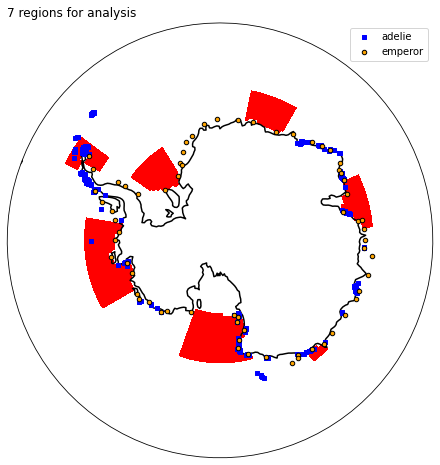

In [32]:
fig = plt.figure(figsize=(10,8))

#cmap = 'ice_cats'

ax = fig.add_subplot(1,1,1, projection=ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -90, -55], ccrs.PlateCarree())
ax.set_title('7 regions for analysis', loc='left')

lon,lat,field = utils.adjust_pop_grid(lons, lats, mask1)
pc1 = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),
                    cmap=plt.cm.get_cmap(cmap,1),
                   vmin=0,vmax=1)

lon,lat,field = utils.adjust_pop_grid(lons, lats, mask2)
pc1 = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),
                    cmap=plt.cm.get_cmap(cmap,1),
                   vmin=0,vmax=1)
lon,lat,field = utils.adjust_pop_grid(lons, lats, mask3)
pc1 = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),
                    cmap=plt.cm.get_cmap(cmap,1),
                   vmin=0,vmax=1)

lon,lat,field = utils.adjust_pop_grid(lons, lats, mask4)
pc1 = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),
                    cmap=plt.cm.get_cmap(cmap,1),
                   vmin=0,vmax=1)

lon,lat,field = utils.adjust_pop_grid(lons, lats, mask5)
pc1 = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),
                    cmap=plt.cm.get_cmap(cmap,1),
                   vmin=0,vmax=1)

lon,lat,field = utils.adjust_pop_grid(lons, lats, mask6)
pc1 = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),
                    cmap=plt.cm.get_cmap(cmap,1),
                   vmin=0,vmax=1)
lon,lat,field = utils.adjust_pop_grid(lons, lats, mask7)
pc1 = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),
                    cmap=plt.cm.get_cmap(cmap,1),
                   vmin=0,vmax=1)

ax.set_boundary(circle, transform=ax.transAxes)
ax.coastlines('110m',linewidth=1.5)


sc_pn = ax.scatter(df_toe_adel.longitude,df_toe_adel.latitude, color='blue', marker='s', zorder=2, s=10, transform=ccrs.PlateCarree(),label='adelie')

sc = ax.scatter(df_toe_emp.longitude,df_toe_emp.latitude, color='orange', s=20, 
                edgecolors='black', zorder=3,transform=ccrs.PlateCarree(),label='emperor')

ax.legend()

##fig.savefig('/glade/work/kristenk/figs/Fig_changing_ice_categories.png', bbox_inches='tight', dpi=300, format='png');